# 📊 Bond Analyzer - Demo Interactivo

Este notebook demuestra el análisis completo de bonos duales argentinos con datos en tiempo real del BCRA.

## Features
- 🏛️ **Integración BCRA**: Datos TAMAR en tiempo real
- 📊 **Análisis Dual**: TEM prospecto vs mercado
- 🔄 **Auto-fetch**: Precios y TIREA automáticos
- 📈 **Conversiones**: TAMAR→TEM, TIREA→TEM
- 📉 **Visualizaciones**: Gráficos interactivos

In [10]:
# Importar todas las funciones del analizador
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

from bond_analyzer import (
    DUAL_BONDS_MAP,
    compute_dual_prospectus_tem,
    compute_market_tem,
    fetch_data912_snapshot,
    resolve_dual_params_from_ticker,
    fetch_tamar_series_values,
    fetch_tamar_latest_decimal,
    tamar_to_tem_monthly,
    tirea_to_tem_monthly,
    DualProspectusParams
)

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import json

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Librerías importadas exitosamente")

✅ Librerías importadas exitosamente


## 📋 Bonos Duales Disponibles

Estos son los bonos duales argentinos que podemos analizar:

In [11]:
# Mostrar bonos disponibles
bonds_df = pd.DataFrame.from_dict(DUAL_BONDS_MAP, orient='index')
bonds_df['fixed_monthly_tem_percent'] = bonds_df['fixed_monthly_tem'] * 100
bonds_df['tirea_percent'] = bonds_df['tirea_decimal'] * 100

display_df = bonds_df[['maturity', 'fixed_monthly_tem_percent', 'tirea_percent']].round(2)
display_df.columns = ['Vencimiento', 'TEM Fija (%)', 'TIREA (%)']

print("🏦 Bonos Duales Argentinos Disponibles:")
display(display_df)

🏦 Bonos Duales Argentinos Disponibles:


,Vencimiento,TEM Fija (%),TIREA (%)
TTM26,2026-03-16,2.25,30.55
TTJ26,2026-06-30,2.19,29.65
TTS26,2026-09-15,2.17,29.31
TTD26,2026-12-15,2.14,28.93


## 🎯 Análisis de Ejemplo: TTM26

Vamos a analizar el bono TTM26 paso a paso:

In [12]:
# Configuración del análisis
TICKER = "TTM26"
TAMAR_ID = 44

print(f"🔍 Analizando bono: {TICKER}")
print(f"📊 Usando TAMAR ID: {TAMAR_ID}")
print(f"📅 Fecha de análisis: {dt.date.today().isoformat()}")

🔍 Analizando bono: TTM26
📊 Usando TAMAR ID: 44
📅 Fecha de análisis: 2025-08-22


### 1️⃣ Obtener Datos de Mercado

In [13]:
# Fetch datos de mercado
print("📡 Obteniendo datos de mercado...")
market_snapshot = fetch_data912_snapshot(TICKER)

print("\n📈 Datos de Mercado Obtenidos:")
for key, value in market_snapshot.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

📡 Obteniendo datos de mercado...

📈 Datos de Mercado Obtenidos:
  ticker: TTM26
  price_per_100: 115.4000
  price_source: arg_bonds.c


### 2️⃣ Análisis TEM de Prospecto

In [14]:
# Calcular TEM de prospecto
print("📋 Calculando TEM de Prospecto...")

dual_params = resolve_dual_params_from_ticker(TICKER)
if dual_params:
    prospecto = compute_dual_prospectus_tem(
        dual_params,
        use_holidays=True,
        tamar_id=TAMAR_ID
    )
    
    print("\n✅ Resultados TEM Prospecto:")
    print(f"  📅 Ventana TAMAR: {prospecto['window_start_10bd']} → {prospecto['window_end_10bd']}")
    print(f"  📊 TAMAR Promedio: {prospecto['tamar_avg_decimal']:.4f} ({prospecto['tamar_avg_decimal']*100:.2f}%)")
    print(f"  📈 TAMAR TEM: {prospecto['tamar_tem']:.4f} ({prospecto['tamar_tem']*100:.2f}%)")
    print(f"  🔒 TEM Fija: {prospecto['fixed_tem']:.4f} ({prospecto['fixed_tem']*100:.2f}%)")
    print(f"  🎯 TEM Prospecto Final: {prospecto['tem_prospectus']:.4f} ({prospecto['tem_prospectus']*100:.2f}%)")
    print(f"  📊 Muestras TAMAR: {prospecto['tamar_samples_count']}")
else:
    print(f"❌ No se encontró configuración para {TICKER}")

📋 Calculando TEM de Prospecto...

✅ Resultados TEM Prospecto:
  📅 Ventana TAMAR: 2025-01-15 → 2026-03-02
  📊 TAMAR Promedio: 0.3442 (34.42%)
  📈 TAMAR TEM: 0.0287 (2.87%)
  🔒 TEM Fija: 0.0225 (2.25%)
  🎯 TEM Prospecto Final: 0.0287 (2.87%)
  📊 Muestras TAMAR: 144


### 3️⃣ Análisis TEM de Mercado

In [15]:
# Calcular TEM de mercado (usando mismos defaults que CLI)
print("💹 Calculando TEM de Mercado...")

maturity_date = market_snapshot.get('maturity_date') or DUAL_BONDS_MAP[TICKER]['maturity']
price = market_snapshot.get('price_per_100')
tirea = market_snapshot.get('tirea_decimal') or DUAL_BONDS_MAP[TICKER]['tirea_decimal']

# Obtener TAMAR más reciente para usar como fuente de mercado (default del CLI)
tamar_latest_decimal = None
try:
    tamar_latest_decimal = fetch_tamar_latest_decimal(TAMAR_ID)
except Exception:
    pass

mercado = compute_market_tem(
    maturity_date=maturity_date,
    settlement_date=dt.date.today(),
    face_value=100.0,
    price_per_100=price,
    tirea_decimal=tirea,
    tamar_latest_decimal=tamar_latest_decimal
)

# Aplicar market_source=tamar como default (igual que CLI)
if tamar_latest_decimal is not None:
    mercado["tem_market"] = tamar_to_tem_monthly(tamar_latest_decimal)
    mercado["tem_market_percentage"] = round(mercado["tem_market"] * 100.0, 2)
    mercado["tem_market_percentage_str"] = f"{mercado['tem_market_percentage']:.2f}%"

print("\n💰 Resultados TEM Mercado:")
print(f"  💵 Precio: ${price:.2f}" if price else "  💵 Precio: No disponible")
print(f"  📈 TIREA: {tirea:.4f} ({tirea*100:.2f}%)" if tirea else "  📈 TIREA: No disponible")
if tamar_latest_decimal:
    print(f"  🏛️ TAMAR Último: {tamar_latest_decimal:.4f} ({tamar_latest_decimal*100:.2f}%)")
if 'tem_from_tirea' in mercado:
    print(f"  🎯 TEM desde TIREA: {mercado['tem_from_tirea']:.4f} ({mercado['tem_from_tirea']*100:.2f}%)")
if 'tem_from_price_bullet' in mercado:
    print(f"  💣 TEM desde Precio: {mercado['tem_from_price_bullet']:.4f} ({mercado['tem_from_price_bullet']*100:.2f}%)")
if 'tem_market' in mercado:
    print(f"  🏆 TEM Mercado Final (TAMAR): {mercado['tem_market']:.4f} ({mercado['tem_market']*100:.2f}%)")

💹 Calculando TEM de Mercado...

💰 Resultados TEM Mercado:
  💵 Precio: $115.40
  📈 TIREA: 0.3055 (30.55%)
  🏛️ TAMAR Último: 0.5881 (58.81%)
  🎯 TEM desde TIREA: 0.0225 (2.25%)
  💣 TEM desde Precio: -0.0208 (-2.08%)
  🏆 TEM Mercado Final (TAMAR): 0.0489 (4.89%)


### 4️⃣ Visualización: Histórico TAMAR

📈 Obteniendo serie histórica TAMAR...


/var/folders/3d/6m5gq2kd38q23v7xdbjvscmr0000gn/T/ipykernel_73625/3991927421.py:46: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3d/6m5gq2kd38q23v7xdbjvscmr0000gn/T/ipykernel_73625/3991927421.py:46: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nicoxis/workspace/tasas/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nicoxis/workspace/tasas/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


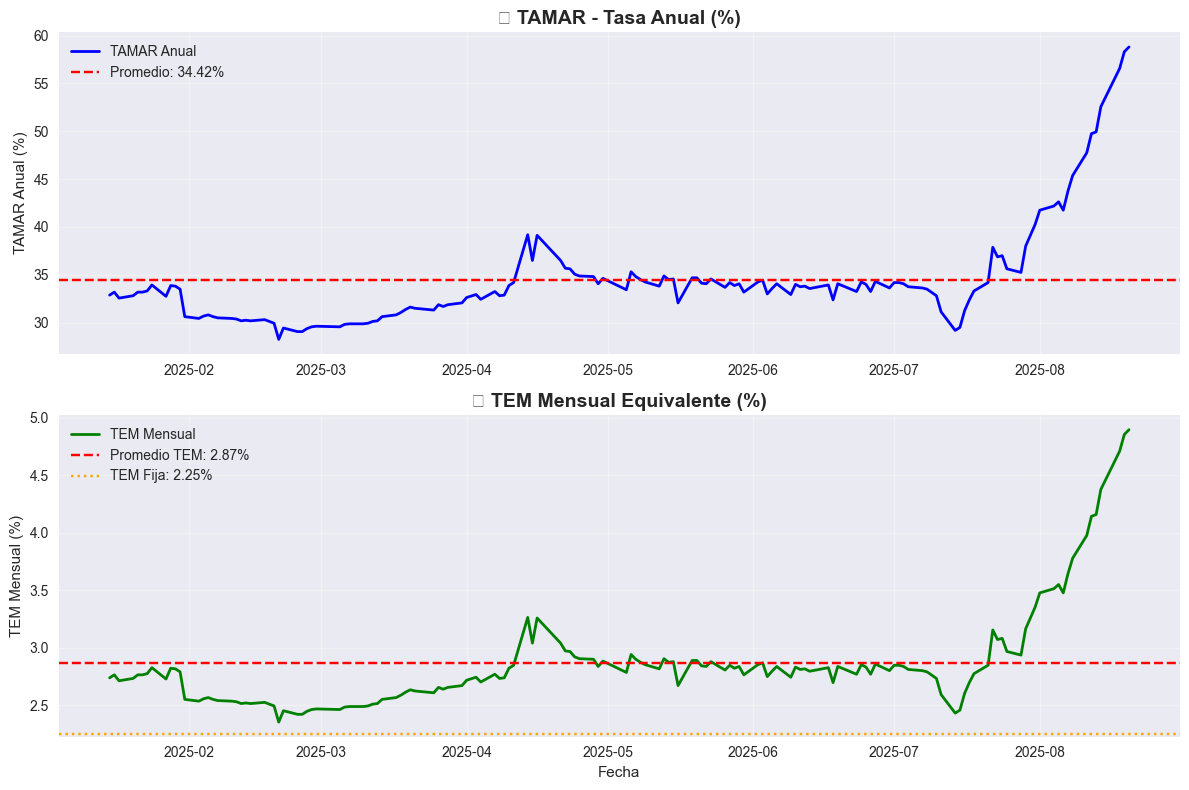


📊 Estadísticas TAMAR (144 observaciones):
  📈 TAMAR Máximo: 58.81%
  📉 TAMAR Mínimo: 28.25%
  📊 TAMAR Promedio: 34.42%
  📊 Desv. Estándar: 5.32%


In [16]:
# Obtener serie histórica TAMAR
print("📈 Obteniendo serie histórica TAMAR...")

if dual_params:
    start_window = prospecto['window_start_10bd']
    end_window = min(dt.date.today(), dt.date.fromisoformat(prospecto['window_end_10bd']))
    
    tamar_series = fetch_tamar_series_values(
        TAMAR_ID, 
        dt.date.fromisoformat(start_window), 
        end_window
    )
    
    if tamar_series:
        # Convertir a DataFrame
        df_tamar = pd.DataFrame(tamar_series)
        df_tamar['fecha'] = pd.to_datetime(df_tamar['fecha'])
        df_tamar['tamar_tem_percent'] = df_tamar['valor_percent'].apply(
            lambda x: tamar_to_tem_monthly(x/100) * 100
        )
        
        # Gráfico
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # TAMAR Anual
        ax1.plot(df_tamar['fecha'], df_tamar['valor_percent'], 'b-', linewidth=2, label='TAMAR Anual')
        ax1.axhline(y=prospecto['tamar_avg_decimal']*100, color='r', linestyle='--', 
                   label=f'Promedio: {prospecto["tamar_avg_decimal"]*100:.2f}%')
        ax1.set_title('📊 TAMAR - Tasa Anual (%)', fontsize=14, fontweight='bold')
        ax1.set_ylabel('TAMAR Anual (%)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # TEM Mensual equivalente
        ax2.plot(df_tamar['fecha'], df_tamar['tamar_tem_percent'], 'g-', linewidth=2, label='TEM Mensual')
        ax2.axhline(y=prospecto['tamar_tem']*100, color='r', linestyle='--',
                   label=f'Promedio TEM: {prospecto["tamar_tem"]*100:.2f}%')
        ax2.axhline(y=prospecto['fixed_tem']*100, color='orange', linestyle=':',
                   label=f'TEM Fija: {prospecto["fixed_tem"]*100:.2f}%')
        ax2.set_title('📈 TEM Mensual Equivalente (%)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Fecha')
        ax2.set_ylabel('TEM Mensual (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Estadísticas TAMAR ({len(df_tamar)} observaciones):")
        print(f"  📈 TAMAR Máximo: {df_tamar['valor_percent'].max():.2f}%")
        print(f"  📉 TAMAR Mínimo: {df_tamar['valor_percent'].min():.2f}%")
        print(f"  📊 TAMAR Promedio: {df_tamar['valor_percent'].mean():.2f}%")
        print(f"  📊 Desv. Estándar: {df_tamar['valor_percent'].std():.2f}%")
    else:
        print("❌ No se pudieron obtener datos históricos TAMAR")
else:
    print("❌ No se pudo analizar el prospecto")

### 5️⃣ Comparación Final: Prospecto vs Mercado

/var/folders/3d/6m5gq2kd38q23v7xdbjvscmr0000gn/T/ipykernel_73625/836084577.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()


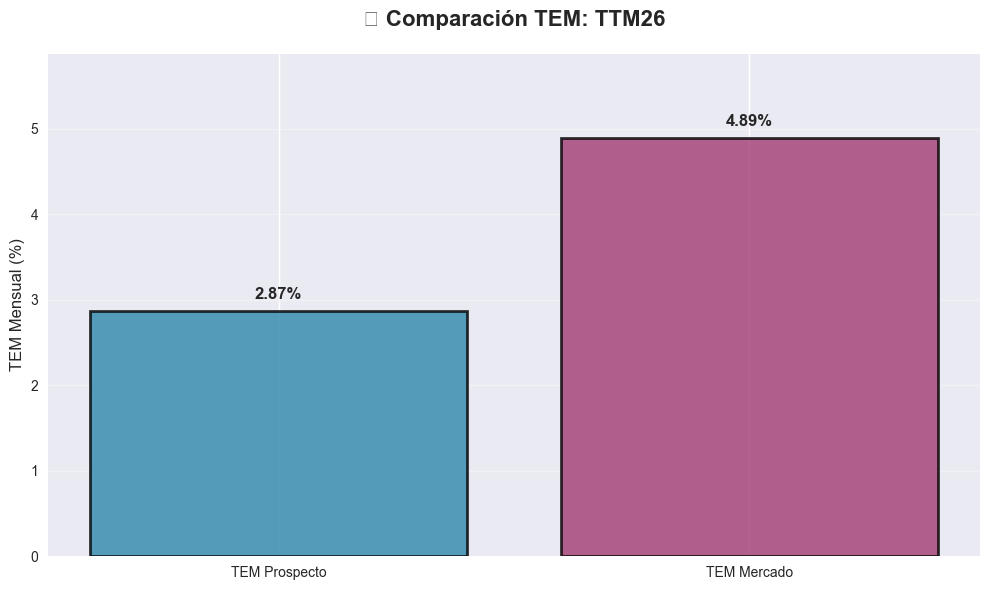


🏆 RESUMEN FINAL:
  📋 TEM Prospecto: 0.0287 (2.87%)
  💹 TEM Mercado: 0.0489 (4.89%)
  📈 Diferencia: 0.0203 (2.03 puntos básicos)
  📊 Diferencia %: 70.76%
  🟢 El mercado cotiza ARRIBA del prospecto


In [17]:
# Comparación final
if dual_params and 'tem_market' in mercado:
    tem_prospecto = prospecto['tem_prospectus']
    tem_mercado = mercado['tem_market']
    
    # Gráfico de comparación
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    categories = ['TEM Prospecto', 'TEM Mercado']
    values = [tem_prospecto * 100, tem_mercado * 100]
    colors = ['#2E86AB', '#A23B72']
    
    bars = ax.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Añadir valores en las barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{value:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax.set_title(f'📊 Comparación TEM: {TICKER}', fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel('TEM Mensual (%)', fontsize=12)
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim(0, max(values) * 1.2)
    
    plt.tight_layout()
    plt.show()
    
    # Resumen numérico
    diferencia = tem_mercado - tem_prospecto
    diferencia_percent = (diferencia / tem_prospecto) * 100
    
    print("\n🏆 RESUMEN FINAL:")
    print(f"  📋 TEM Prospecto: {tem_prospecto:.4f} ({tem_prospecto*100:.2f}%)")
    print(f"  💹 TEM Mercado: {tem_mercado:.4f} ({tem_mercado*100:.2f}%)")
    print(f"  📈 Diferencia: {diferencia:.4f} ({diferencia*100:.2f} puntos básicos)")
    print(f"  📊 Diferencia %: {diferencia_percent:.2f}%")
    
    if tem_mercado > tem_prospecto:
        print("  🟢 El mercado cotiza ARRIBA del prospecto")
    else:
        print("  🔴 El mercado cotiza ABAJO del prospecto")

else:
    print("❌ No se pudo completar la comparación")

## 🎮 Prueba con Otros Bonos

Puedes cambiar el ticker en la siguiente celda para probar otros bonos:

In [18]:
# Función para análisis rápido de cualquier bono (con defaults del CLI)
def analyze_bond_quick(ticker):
    """
    Análisis rápido de cualquier bono dual usando mismos defaults que CLI
    """
    print(f"🔍 Analizando {ticker}...")
    
    # Verificar si existe
    if ticker.upper() not in DUAL_BONDS_MAP:
        print(f"❌ {ticker} no está en la lista de bonos duales")
        return
    
    # Parámetros
    dual_params = resolve_dual_params_from_ticker(ticker)
    market_snap = fetch_data912_snapshot(ticker)
    
    # Prospecto con TAMAR ID 44
    prospecto = compute_dual_prospectus_tem(dual_params, tamar_id=44)
    
    # Mercado con market_source=tamar (default CLI)
    maturity = market_snap.get('maturity_date') or DUAL_BONDS_MAP[ticker.upper()]['maturity']
    tirea = market_snap.get('tirea_decimal') or DUAL_BONDS_MAP[ticker.upper()]['tirea_decimal']
    price = market_snap.get('price_per_100')
    
    # Obtener TAMAR más reciente
    tamar_latest_decimal = None
    try:
        tamar_latest_decimal = fetch_tamar_latest_decimal(44)  # Default TAMAR ID
    except Exception:
        pass
    
    mercado = compute_market_tem(
        maturity_date=maturity,
        settlement_date=dt.date.today(),
        face_value=100.0,
        price_per_100=price,
        tirea_decimal=tirea,
        tamar_latest_decimal=tamar_latest_decimal
    )
    
    # Aplicar market_source=tamar como default
    if tamar_latest_decimal is not None:
        mercado["tem_market"] = tamar_to_tem_monthly(tamar_latest_decimal)
    
    # Resultados
    print(f"\n📊 Resultados {ticker.upper()}:")
    print(f"  📅 Vencimiento: {maturity}")
    print(f"  💵 Precio: ${price}" if price else "  💵 Precio: N/A")
    print(f"  📋 TEM Prospecto: {prospecto['tem_prospectus']*100:.2f}%")
    print(f"  💹 TEM Mercado (TAMAR): {mercado.get('tem_market', 0)*100:.2f}%")
    
    return {
        'ticker': ticker.upper(),
        'prospecto': prospecto['tem_prospectus'],
        'mercado': mercado.get('tem_market', 0)
    }

# Probar con diferentes bonos
bonos_test = ['TTM26', 'TTJ26', 'TTS26', 'TTD26']
resultados = []

for bono in bonos_test:
    try:
        resultado = analyze_bond_quick(bono)
        if resultado:
            resultados.append(resultado)
        print("-" * 50)
    except Exception as e:
        print(f"❌ Error analizando {bono}: {e}")
        print("-" * 50)

print("\n🏆 RESUMEN COMPARATIVO:")
if resultados:
    df_resumen = pd.DataFrame(resultados)
    df_resumen['prospecto_pct'] = df_resumen['prospecto'] * 100
    df_resumen['mercado_pct'] = df_resumen['mercado'] * 100
    df_resumen['diferencia_pct'] = df_resumen['mercado_pct'] - df_resumen['prospecto_pct']
    
    display_cols = ['ticker', 'prospecto_pct', 'mercado_pct', 'diferencia_pct']
    df_display = df_resumen[display_cols].round(2)
    df_display.columns = ['Ticker', 'TEM Prospecto (%)', 'TEM Mercado (%)', 'Diferencia (pb)']
    
    display(df_display)

🔍 Analizando TTM26...

📊 Resultados TTM26:
  📅 Vencimiento: 2026-03-16
  💵 Precio: $115.4
  📋 TEM Prospecto: 2.87%
  💹 TEM Mercado (TAMAR): 4.89%
--------------------------------------------------
🔍 Analizando TTJ26...

📊 Resultados TTJ26:
  📅 Vencimiento: 2026-06-30
  💵 Precio: $110.6
  📋 TEM Prospecto: 2.87%
  💹 TEM Mercado (TAMAR): 4.89%
--------------------------------------------------
🔍 Analizando TTS26...

📊 Resultados TTS26:
  📅 Vencimiento: 2026-09-15
  💵 Precio: $108.35
  📋 TEM Prospecto: 2.87%
  💹 TEM Mercado (TAMAR): 4.89%
--------------------------------------------------
🔍 Analizando TTD26...

📊 Resultados TTD26:
  📅 Vencimiento: 2026-12-15
  💵 Precio: $107.25
  📋 TEM Prospecto: 2.87%
  💹 TEM Mercado (TAMAR): 4.89%
--------------------------------------------------

🏆 RESUMEN COMPARATIVO:


,Ticker,TEM Prospecto (%),TEM Mercado (%),Diferencia (pb)
0,TTM26,2.87,4.89,2.03
1,TTJ26,2.87,4.89,2.03
2,TTS26,2.87,4.89,2.03
3,TTD26,2.87,4.89,2.03


## 📚 Información Técnica

### Fórmulas utilizadas:

**TAMAR → TEM:**
```
TAMAR_TEM = [(1+TAMAR/((365/32)))^((365/32))]^((1/12))-1
```

**TIREA → TEM:**
```
TEM = (1+TIREA)^(1/12)-1
```

**TEM Prospecto:**
```
TEM_Prospecto = MAX(TEM_Fija, TAMAR_TEM_Promedio)
```

### Fuentes de Datos:
- 🏛️ **BCRA**: API oficial para datos TAMAR históricos
- 📊 **Data912**: Precios de bonos en tiempo real
- 📋 **Argentina.gob.ar**: Parámetros oficiales de prospecto

